In [ ]:
#solving the imbalance problem of the data 

In [33]:
!pip install pandas scikit-learn imbalanced-learn
import pandas as pd
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Load the dataset (replace 'your_original_data.csv' with your file path)
input_file = 'predictive_maintenance_modified_2.csv'  # Correct path to your file
output_file = 'balanced_data.csv'                     # Output file name
data = pd.read_csv(input_file)

# Handle non-numeric columns (encoding categorical columns)
label_encoder = LabelEncoder()

# Encode all categorical columns (e.g., 'Product ID', 'Failure Type', 'Type')
categorical_columns = ['Product ID', 'Failure Type', 'Type']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Split features (X) and target (y)
X = data.drop(columns=['Target'])
y = data['Target']

# Display the original class distribution
print("Original class distribution:", Counter(y))

# Apply SMOTETomek to combine oversampling and undersampling
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

# Display the new class distribution after balancing
print("Balanced class distribution:", Counter(y_resampled))

# Combine the resampled data back into a DataFrame
balanced_data = pd.concat([X_resampled, y_resampled], axis=1)

# Save the balanced data to a new CSV file
balanced_data.to_csv(output_file, index=False)

print(f"Balanced data saved to {output_file}")

Original class distribution: Counter({0: 9661, 1: 339})
Balanced class distribution: Counter({0: 9478, 1: 9478})
Balanced data saved to balanced_data.csv


In [ ]:
## import the necessary libraries

In [4]:
!pip install seaborn
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [36]:
# read the csv file 
pred_df = pd.read_csv("balanced_data_semicolon.csv", sep=";")

In [37]:
pred_df.head()

,Failure Type,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1,1,7003,2,298.1,308.6,1551,42.8,0,0
1,1,2,1003,1,298.2,308.7,1408,46.3,3,0
2,1,3,1004,1,298.1,308.5,1498,49.4,5,0
3,1,4,1005,1,298.2,308.6,1433,39.5,7,0
4,1,5,1006,1,298.2,308.7,1408,40.0,9,0


#  PERFORM EXPLORATORY DATA ANALYSIS

In [38]:
pred_df = pred_df.drop(columns = 'UDI')
pred_df = pred_df.drop(columns = 'Failure Type')
pred_df = pred_df.drop(columns = 'Product ID')

In [39]:
pred_df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0


In [40]:
# checking the null values
pred_df.isnull().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
dtype: int64

In [41]:
# Checking the dataframe information

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18956 entries, 0 to 18955
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     18956 non-null  int64  
 1   Air temperature [K]      18956 non-null  float64
 2   Process temperature [K]  18956 non-null  float64
 3   Rotational speed [rpm]   18956 non-null  int64  
 4   Torque [Nm]              18956 non-null  float64
 5   Tool wear [min]          18956 non-null  int64  
 6   Target                   18956 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.0 MB


In [42]:
# Statistical summary of the dataframe
pred_df.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,18956.000000,18956.000000,18956.000000,18956.000000,18956.000000,18956.000000,18956.000000
mean,1.187381,300.452764,310.152994,1505.499894,45.314593,125.387107,0.500000
std,0.561136,2.083431,1.409836,270.067613,13.403063,66.070295,0.500013
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,1.000000,298.688723,309.067379,1353.000000,36.800000,69.000000,0.000000
50%,1.000000,300.612809,310.327620,1422.000000,46.898527,129.000000,0.500000
75%,2.000000,302.257916,311.130398,1555.000000,54.824733,187.000000,1.000000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


#  CREATE TRAINING AND TESTING DATASET #

In [43]:
# split the dataframe into target and features

df_target = pred_df['Target']
df_final = pred_df.drop(columns =['Target'])

In [44]:
pred_df.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target'],
      dtype='object')

In [45]:
df_final.shape

(18956, 6)

In [46]:
df_target.shape

(18956,)

In [47]:
#spliting the data in to test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_final, df_target, test_size = 0.2)



In [48]:
X_train.shape

(15164, 6)

In [49]:
y_train.shape

(15164,)

In [50]:
X_test.shape

(3792, 6)

In [51]:
X_test.shape

(3792, 6)

#  TRAIN AND TEST XGBOOST MODEL IN LOCAL MODE (NOTE THAT SAGEMAKER BUILT-IN ALGORITHMS ARE NOT USED HERE)

In [52]:
# install xgboost

!pip install xgboost

In [55]:
# use xgboost model in local mode

# note that we have not performed any normalization or scaling since XGBoost is not sensitive to this.
# XGboost is a type of ensemble algorithms and works by selecting thresholds or cut points on features to split a node. 
# It doesn't really matter if the features are scaled or not.


from xgboost import XGBClassifier

# model = XGBClassifier(learning_rate=0.01, n_estimators=100, objective='binary:logistic')
model = XGBClassifier()


# Replace problematic characters in feature names
X_train.columns = X_train.columns.str.replace(r'[\[\]<]', '', regex=True)
X_test.columns = X_test.columns.str.replace(r'[\[\]<]', '', regex=True)



model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [56]:
# make predictions on test data

predict = model.predict(X_test)

In [57]:
predict

array([0, 0, 1, ..., 1, 0, 0])

<Axes: >

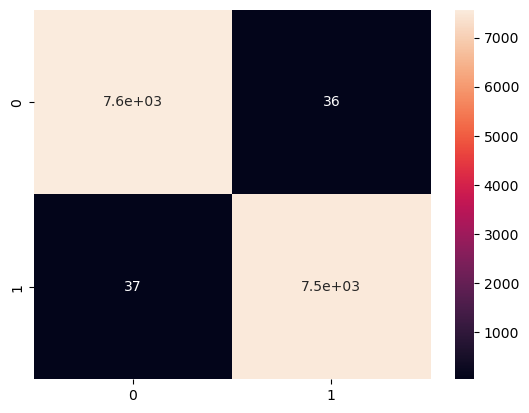

In [58]:
# Assess trained model performance on training dataset
predict_train = model.predict(X_train)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predict_train)
plt.figure()
sns.heatmap(cm, annot=True)

In [59]:
# print metrics for training dataset

from sklearn.metrics import precision_score, recall_score, accuracy_score

print("Precision = {}".format(precision_score(y_train, predict_train)))
print("Recall = {}".format(recall_score(y_train, predict_train)))
print("Accuracy = {}".format(accuracy_score(y_train, predict_train)))

Precision = 0.9952374652731842
Recall = 0.9951058201058202
Accuracy = 0.995185966763387


In [60]:
# print metrics for testing dataset

print("Precision = {}".format(precision_score(y_test, predict)))
print("Recall = {}".format(recall_score(y_test, predict)))
print("Accuracy = {}".format(accuracy_score(y_test, predict)))

Precision = 0.9699481865284975
Recall = 0.9760166840458812
Accuracy = 0.9725738396624473


<Axes: >

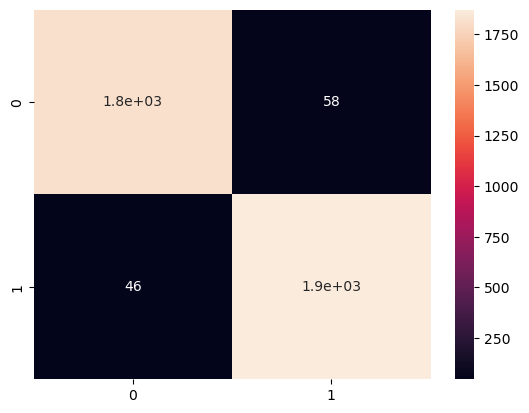

In [61]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict)
plt.figure()
sns.heatmap(cm, annot=True)

#  PERFORM DIMENSIONALITY REDUCTION USING PCA ( USING SAGEMAKER)

In [74]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developer to write software that makes use of services like Amazon S3 and Amazon EC2



import sagemaker
import boto3

# Let's create a Sagemaker session
sagemaker_session = sagemaker.Session()
bucket = 'predictive-maintenance-sensor-data'
prefix = 'pca'  # prefix is the subfolder within the bucket.

#Let's get the execution role for the notebook instance. 
# This is the IAM role that you created when you created your notebook instance. You pass the role to the training job.
# Note that AWS Identity and Access Management (IAM) role that Amazon SageMaker can assume to perform tasks on your behalf (for example, reading training results, called model artifacts, from the S3 bucket and writing training results to Amazon S3). 

role = sagemaker.get_execution_role()

In [76]:
df_final

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,2,298.100000,308.600000,1551,42.800000,0
1,1,298.200000,308.700000,1408,46.300000,3
2,1,298.100000,308.500000,1498,49.400000,5
3,1,298.200000,308.600000,1433,39.500000,7
4,1,298.200000,308.700000,1408,40.000000,9
...,...,...,...,...,...,...
18951,0,300.499654,309.900000,1396,45.901385,210
18952,2,298.209838,308.509838,2616,13.159450,87
18953,1,298.847085,310.214742,1725,27.132343,197
18954,2,300.852094,310.426047,1534,45.509505,169


In [77]:
import io # The io module allows for dealing with various types of I/O (text I/O, binary I/O and raw I/O). 
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker PCA

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
df_matrix = df_final.to_numpy() # convert the dataframe into 2-dimensional array
smac.write_numpy_to_dense_tensor(buf, df_matrix)
buf.seek(0)

# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 

0

In [78]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file 
 
key = 'pca'

#following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)


print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://predictive-maintenance-sensor-data/pca/train/pca


In [79]:
# create output placeholder in S3 bucket to store the PCA output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://predictive-maintenance-sensor-data/pca/output


In [80]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the pca container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session


from sagemaker.amazon.amazon_estimator import get_image_uri


container = get_image_uri(boto3.Session().region_name, 'pca')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [81]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training


pca = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session)

# We can tune parameters like the number of features that we are passing in, mode of algorithm, mini batch size and number of pca components


pca.set_hyperparameters(feature_dim=6,
                        num_components=4,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=100)


# Pass in the training data from S3 to train the pca model


pca.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: pca-2024-10-06-12-54-51-682


2024-10-06 12:54:53 Starting - Starting the training job...
2024-10-06 12:55:07 Starting - Preparing the instances for training...
2024-10-06 12:55:34 Downloading - Downloading input data...
2024-10-06 12:55:59 Downloading - Downloading the training image......
2024-10-06 12:57:25 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[10/06/2024 12:57:36 INFO 140396485506880] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[10/06/2024 12:57:36

#  DEPLOY THE TRAINED PCA MODEL 

In [82]:
# Deploy the model to perform inference 

pca_reduction = pca.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: pca-2024-10-06-12-59-23-788
INFO:sagemaker:Creating endpoint-config with name pca-2024-10-06-12-59-23-788
INFO:sagemaker:Creating endpoint with name pca-2024-10-06-12-59-23-788


---------------!

In [84]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Content type overrides the data that will be passed to the deployed model, since the deployed model expects data in text/csv format.

# Serializer accepts a single argument, the input data, and returns a sequence of bytes in the specified content type

# Deserializer accepts two arguments, the result data and the response content type, and return a sequence of bytes in the specified content type.


# Update the serializer and deserializer assignments
pca_reduction.content_type = 'text/csv'
pca_reduction.serializer = CSVSerializer()
pca_reduction.deserializer = JSONDeserializer()


In [85]:
# make prediction on the test data

result = pca_reduction.predict(np.array(df_final))

In [86]:
result # results are in Json format

{'projections': [{'projection': [1.0653276443481445,
    94.02693176269531,
    81.28988647460938,
    1605.01806640625]},
  {'projection': [-1.4347362518310547,
    108.39442443847656,
    42.46070861816406,
    1468.0877685546875]},
  {'projection': [5.278266906738281,
    97.0809326171875,
    63.5062255859375,
    1554.6768798828125]},
  {'projection': [-7.021724700927734,
    101.44011688232422,
    47.60182189941406,
    1492.196533203125]},
  {'projection': [-7.590389728546143,
    102.82833862304688,
    39.86639404296875,
    1468.38134765625]},
  {'projection': [-5.036481857299805,
    99.5806884765625,
    42.63128662109375,
    1484.8714599609375]},
  {'projection': [0.8508129119873047,
    82.40367126464844,
    74.26568603515625,
    1612.8079833984375]},
  {'projection': [-2.562899589538574,
    84.01588439941406,
    65.58154296875,
    1583.1402587890625]},
  {'projection': [-8.163158416748047,
    65.13326263427734,
    101.78817749023438,
    1717.452392578125]},
  {

In [87]:
# Since the results are in Json format, we access the scores by iterating through the scores in the predictions
predictions = np.array([r['projection'] for r in result['projections']])

In [88]:
predictions

array([[ 1.06532764e+00,  9.40269318e+01,  8.12898865e+01,
         1.60501807e+03],
       [-1.43473625e+00,  1.08394424e+02,  4.24607086e+01,
         1.46808777e+03],
       [ 5.27826691e+00,  9.70809326e+01,  6.35062256e+01,
         1.55467688e+03],
       ...,
       [-9.00864029e+00, -7.84754944e+01,  2.26043701e+00,
         1.78730750e+03],
       [ 8.63277435e-01, -3.17532349e+01, -3.29081116e+01,
         1.60267773e+03],
       [-3.54437733e+00,  2.94623032e+01, -3.97183762e+01,
         1.44412915e+03]])

In [89]:
predictions.shape

(18956, 4)

In [90]:
# Delete the end-point

pca_reduction.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pca-2024-10-06-12-59-23-788
INFO:sagemaker:Deleting endpoint with name: pca-2024-10-06-12-59-23-788


# TRAIN AND EVALUATE XGBOOST MODEL ON DATA AFTER DIMENSIONALITY REDUCTION (USING SAGEMAKER)

In [128]:
predictions.shape

(18956, 4)

In [129]:
# Convert the array into dataframe in a way that target variable is set as the first column and is followed by feature columns
# This is because sagemaker built-in algorithm expects the data in this format

train_data = pd.DataFrame({'Target':df_target})
train_data

,Target
0,0
1,0
2,0
3,0
4,0
...,...
18951,1
18952,1
18953,1
18954,1


In [130]:
for i in range(predictions.shape[1]):
    train_data[i] = predictions[:,i]

In [131]:
train_data.head()

,Target,0,1,2,3
0,0,1.065328,94.026932,81.289886,1605.018066
1,0,-1.434736,108.394424,42.460709,1468.087769
2,0,5.278267,97.080933,63.506226,1554.676880
3,0,-7.021725,101.440117,47.601822,1492.196533
4,0,-7.590390,102.828339,39.866394,1468.381348


In [132]:
train_data_size = int(0.9 * train_data.shape[0])
train_data_size

17060

In [148]:
# shuffle the data in dataframe and then split the dataframe into train, test and validation sets.

#import sklearn 

#train_data = sklearn.utils.shuffle(train_data)
#train, test, valid = train_data[:train_data_size], train_data[train_data_size:train_data_size + 3500], train_data[train_data_size + 3500:]


from sklearn.model_selection import train_test_split

# Define the split sizes (e.g., 70% training, 15% test, 15% validation)
train_size = 0.7
test_size = 0.15
valid_size = 0.15

# First, split the data into training and remaining data (test + validation)
train, remaining = train_test_split(train_data, train_size=train_size, shuffle=True, random_state=42)

# Then, split the remaining data into test and validation
test, valid = train_test_split(remaining, test_size=valid_size/(test_size + valid_size), random_state=42)

# Check the shapes of the datasets to ensure correct splitting
print(f'Train set: {train.shape}')
print(f'Test set: {test.shape}')
print(f'Validation set: {valid.shape}')




Train set: (13269, 5)
Test set: (2843, 5)
Validation set: (2844, 5)


In [150]:
train.shape, test.shape,valid.shape

((13269, 5), (2843, 5), (2844, 5))

In [151]:
X_test, y_test = test.drop(columns = ['Target']), test['Target']

In [152]:
# save train_data and validation_data as csv files

train.to_csv('train.csv',header = False, index = False)
valid.to_csv('valid.csv',header = False, index = False)

In [153]:
prefix = 'XGBoost-Classifier'
key = 'XGBoost-Classifier'

In [154]:
# read the data from csv file and then upload the data to s3 bucket
with open('train.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://predictive-maintenance-sensor-data/XGBoost-Classifier/train/XGBoost-Classifier


In [155]:
# reading the data from csv file and then upload the data to s3 bucket
with open('valid.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'valid', key)).upload_fileobj(f)

# Let's print out the validation data location in s3
s3_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_valid_data))

uploaded validation data location: s3://predictive-maintenance-sensor-data/XGBoost-Classifier/valid/XGBoost-Classifier


In [156]:
# creates output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://predictive-maintenance-sensor-data/XGBoost-Classifier/output


In [157]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the XGBoost container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session


container = get_image_uri(boto3.Session().region_name, 'xgboost','0.90-2')



See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [158]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training


Xgboost_classifier = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session)

# To improve the performance of the model, a hyperparameters tuning job need to be run 

Xgboost_classifier.set_hyperparameters(max_depth=3,
                           objective='multi:softmax',
                           num_class= 2,
                           eta = 0.5,
                           num_round = 150
                           )

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [159]:
# Create "train", "validation" channels to feed in the model
# Source: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

import sagemaker
from sagemaker.inputs import TrainingInput

# Specify the correct paths to your training and validation data in S3
s3_train_data = 's3://predictive-maintenance-sensor-data/XGBoost-Classifier/train/train2.libsvm'   
s3_valid_data = 's3://predictive-maintenance-sensor-data/XGBoost-Classifier/valid/valid2.libsvm'

# Define the input channels for training and validation data
#train_input = TrainingInput(s3_data=s3_train_data, content_type='csv', s3_data_type='S3Prefix')
#valid_input = TrainingInput(s3_data=s3_valid_data, content_type='csv', s3_data_type='S3Prefix')

# Fit the XGBoost classifier
Xgboost_classifier.fit({'train': s3_train_data, 'validation': s3_valid_data})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-10-06-16-20-23-862


2024-10-06 16:20:26 Starting - Starting the training job...
2024-10-06 16:20:39 Starting - Preparing the instances for training...
2024-10-06 16:21:12 Downloading - Downloading input data...
2024-10-06 16:21:37 Downloading - Downloading the training image...
2024-10-06 16:22:17 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[16:22:32] 13268x4 matrix with 53072 entries loaded from /opt/ml/input/data/train
[16:22:32] 2843x4 matrix with 11372 entries loaded from /opt/ml/input/data/validation
INFO:root:Single node training.
[2024-10-06 16:22:32.899 ip-10-0-112-224.ec2.internal:7 INFO json_config.py:90] Creating

#  DEPLOY AND TEST THE TRAINED XGBOOST MODEL 

In [160]:
# Deploy the model to perfrom inference 

Xgboost_classifier = Xgboost_classifier.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-10-06-16-28-21-993
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-10-06-16-28-21-993
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-10-06-16-28-21-993


------!

In [ ]:
# Delete the end-point

Xgboost_classifier.delete_endpoint()